In [1]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# utilities 
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, save_or_load_onehot, build_data, plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison)
from utils.utils_model_full_tensor import Network, train, evaluate
import wandb
tqdm.pandas()

plt.rcParams["mathtext.fontset"] = "cm"
fontsize = 24
textsize = 16
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize
plt.rcParams['text.usetex'] = False
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


torch device: cuda:0


In [2]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

# Replace with your Materials Project API key
API_KEY = "zckQao2291DWQRcIyq96cAwvZH9DAdTy"
# MATERIAL_ID = "mp-7173"  # Cubic used in training
MATERIAL_ID = "mp-540872" # Cubic not used in training
# MATERIAL_ID = "mp-9538" # Orthorhombic not used in training



# Step 1: Query the material by Material ID and get the structure
with MPRester(API_KEY) as mpr:
    structure = mpr.get_structure_by_material_id(MATERIAL_ID)

# Step 2: Use SpacegroupAnalyzer to refine the structure
sym_prec = 1e-2
spacegroup_analyzer = SpacegroupAnalyzer(structure, symprec=sym_prec)
refined_structure = spacegroup_analyzer.get_refined_structure()

# Step 3: Convert the refined structure to an ASE Atoms object
ase_atoms = AseAtomsAdaptor.get_atoms(refined_structure)
crystal_system = spacegroup_analyzer.get_crystal_system()

# Optional: Print some details to verify
print(f"Material ID: {MATERIAL_ID}")
print(f"Spacegroup (before refinement): {spacegroup_analyzer.get_space_group_symbol()}")
print(f"Spacegroup (after refinement): {SpacegroupAnalyzer(refined_structure).get_space_group_symbol()}")
print(f"Number of atoms in ASE object: {len(ase_atoms)}")
print(f"Chemical symbols: {ase_atoms.get_chemical_symbols()}")
print(f"Cell parameters: {ase_atoms.cell}")


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Material ID: mp-540872
Spacegroup (before refinement): Fd-3m
Spacegroup (after refinement): Fd-3m
Number of atoms in ASE object: 80
Chemical symbols: ['Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'Sb', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Cell parameters: Cell([10.28144544, 10.28144544, 10.28144544])


In [3]:
import numpy as np
import pandas as pd
import torch
from ase import Atoms
from tqdm import tqdm
from ase.geometry import cellpar_to_cell, cell_to_cellpar

def apply_monoclinic_strain(atoms, angle_strain_deg):
    """
    Apply a monoclinic distortion by changing the beta angle
    (the angle between a and c axis) while keeping lengths fixed.

    Parameters:
    - atoms: ASE Atoms object
    - angle_strain_deg: amount to change beta angle, in degrees
      (e.g., +1° would make beta = 91° if starting from 90°)
    """
    strained = atoms.copy()
    cell = strained.get_cell()
    
    # Convert to cell parameters: [a, b, c, alpha, beta, gamma]
    cellpar = cell_to_cellpar(cell)

    # Apply strain to the beta angle (keep others)
    cellpar[4] += angle_strain_deg  # beta index is 4

    # Build new cell
    new_cell = cellpar_to_cell(cellpar)

    # Set the new strained cell
    strained.set_cell(new_cell, scale_atoms=True)
    return strained

def apply_tetragonal_strain(atoms, strain_percent):
    strained = atoms.copy()
    strain = 1.0 + strain_percent / 100.0
    cell = strained.get_cell()
    cell[2, :] *= strain  # stretch z
    strained.set_cell(cell, scale_atoms=True)
    return strained

def build_strained_dataset(
    base_atoms, strain_list, MATERIAL_ID, crystal_system, new_x, dummy_tensor, build_data_fn, scale_data, r_max,
    type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding
):
    all_rows = []

    for strain in strain_list:
        strained_atoms = apply_tetragonal_strain(base_atoms, strain)
        # strained_atoms = apply_monoclinic_strain(base_atoms, strain)

        row = {
            "mp_id": f"{MATERIAL_ID}_strain_{strain}",
            "formula": strained_atoms.get_chemical_formula(),
            "symmetrized_structure": strained_atoms,
            "energies_interp": new_x,
            "imag_Permittivity_Matrices_interp": dummy_tensor.copy(),
            "crystal_system": crystal_system
        }

        # Cartesian → Spherical (zero tensor placeholder)
        x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
        place_holder = torch.from_numpy(dummy_tensor.copy()).float()
        sph_coefs_tensor = x.from_cartesian(place_holder)
        row["sph_coefs"] = sph_coefs_tensor.cpu().numpy()

        all_rows.append(row)

    df_strained = pd.DataFrame(all_rows)

    # Build graphs
    df_strained["data"] = df_strained.progress_apply(
        lambda x: build_data_fn(
            x, "sph_coefs", scale_data,
            type_onehot, mass_onehot, dipole_onehot, radius_onehot,
            type_encoding, r_max
        ), axis=1
    )

    return df_strained


In [4]:
# Parameters
energy_min = 0  # eV
energy_max = 30  # eV
nstep = 301
new_x = np.linspace(energy_min, energy_max, nstep)
dummy_tensor = np.zeros((nstep, 3, 3))



type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

# Find the scaling value
scale_data = 9.660251973905062
n_train = 42.50108904548367
print(scale_data)


r_max = 6. # cutoff radius

# strain_levels = np.arange(0, 5.5, 0.5)  # 0%, 0.5%, ..., 5%
strain_levels = np.linspace(0,5,6)  # 0%, 0.5%, ..., 5%

# angle_list = np.arange(0, 10, 0.5)  # [-2.0, -1.5, ..., +2.0] degrees relative to 90°
angle_list = np.linspace(0, 10, 6)  # [-2.0, -1.5, ..., +2.0] degrees relative to 90°

# print(len(angle_list))
df = build_strained_dataset(
    base_atoms=ase_atoms,
    strain_list=strain_levels,
    MATERIAL_ID="mp-7173",
    crystal_system="tetragonal",
    new_x=new_x,
    dummy_tensor=dummy_tensor,
    build_data_fn=build_data,
    scale_data=scale_data,
    r_max=r_max,
    type_onehot=type_onehot,
    mass_onehot=mass_onehot,
    dipole_onehot=dipole_onehot,
    radius_onehot=radius_onehot,
    type_encoding=type_encoding
)

run_time = '250424'

## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim , **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        # data.x_mass = F.relu(self.em_mass(data.x_mass))
        # data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        # data.x_radius = F.relu(self.em_radius(data.x_radius))
        # crystal_system_embed = F.relu(self.em_crystal_system(data.crystal_system_onehot))  # Shape: (em_dim,)
        # num_nodes = data.x_mass.shape[0]
        # if hasattr(data, 'batch') and data.batch is not None:
        #     crystal_system_embed = crystal_system_embed[data.batch]  # Shape: (num_nodes, em_dim)
        # else:
        #     # Single graph case: repeat for all nodes
        #     crystal_system_embed = crystal_system_embed.squeeze(0).repeat(num_nodes, 1)  # Shape: (num_nodes, em_dim)    
            
        # # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius, crystal_system_embed], dim=0)  # Shape: (4, num_nodes, em_dim)        
        # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)  # Shape: (3, num_nodes, em_dim)        

        # tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        # data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # RELU issue, from e3nn discussion, removing because it might break the symmetry
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # take mean over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples
        return output

out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64

use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train,
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
run_name = f'symmetrized_data_model_im_{run_time}_for_paper'

wandb.init(
    project="Prediction",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)

# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse_sph'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

predictions = [] 
df['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5) 

        loss_0e = F.mse_loss(output_0e, y_0e)   
        loss_2e = F.mse_loss(output_2e, y_2e)   
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'imag_Permittivity_Matrices_interp'

df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) * scale_data


sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  

x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays
wandb.finish()


Loading existing data...
9.660251973905062


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]
wandb: Currently logged in as: hsu-ting (hsu-ting-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


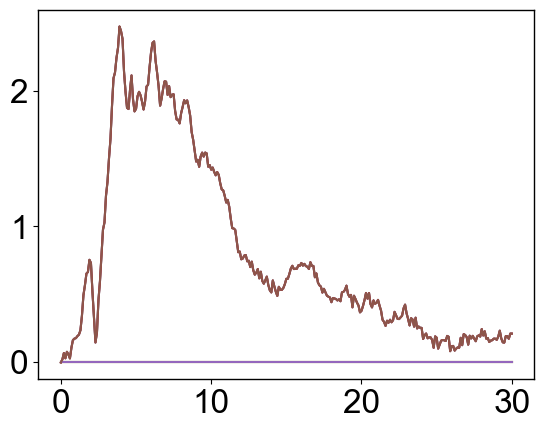

In [5]:
for i in range(3):
    for j in range(i,3):
        plt.plot(df.iloc[0]["energies_interp"], df.iloc[0]["y_pred_cart"][:,i,j])
plt.show()

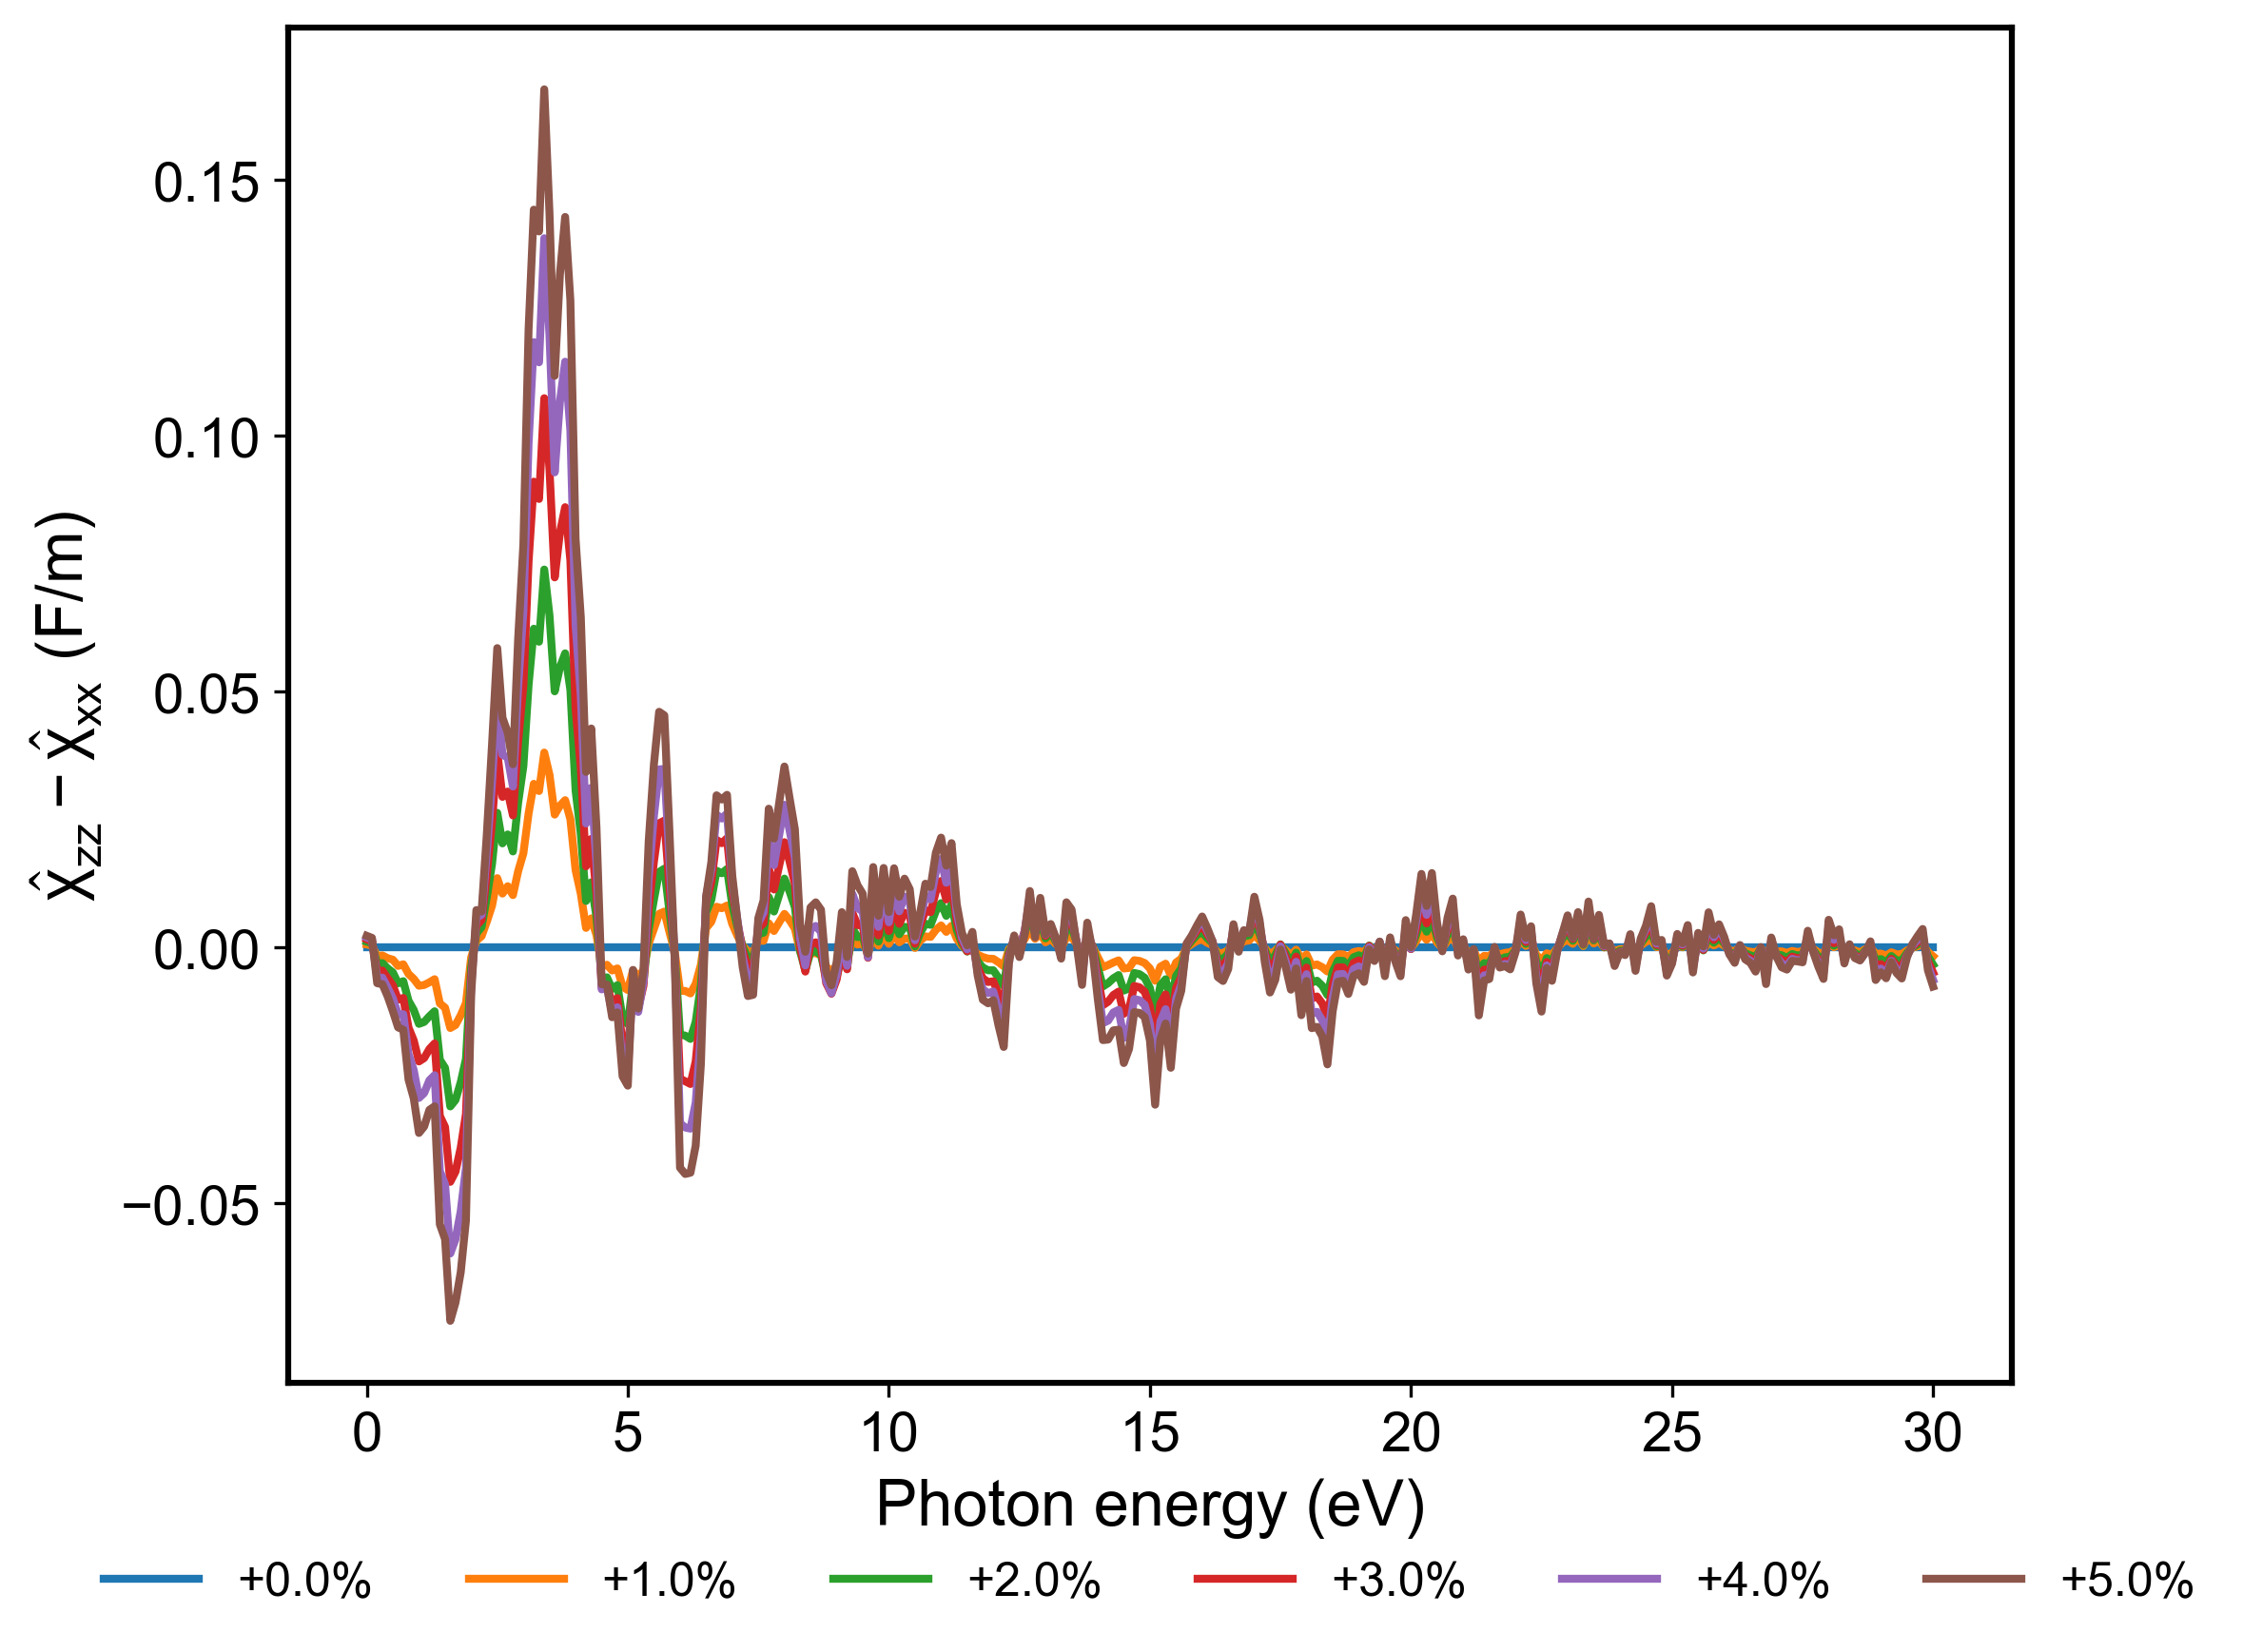

In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np

# Set font sizes for professional appearance
fontsize = 18
textsize = 14
plt.rcParams.update({
    "font.size": fontsize-4,
    "axes.labelsize": fontsize-2,
    "axes.titlesize": fontsize,
    "legend.fontsize": textsize-2,
    "xtick.labelsize": textsize,
    "ytick.labelsize": textsize,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.0,
    "savefig.dpi": 300,
    "figure.dpi": 150
})
# Initialize figure
fig, ax = plt.subplots(figsize=(8, 6),dpi = 300)

# Calculate σ_zz - σ_xx if not already calculated
df["delta_zz_xx"] = df["y_pred_cart"].map(lambda x: x[:, 2, 2] - x[:, 0, 0])
# df["delta_zz_xx"] = df["y_pred_cart"].map(lambda x: x[:, 0, 2])

# Plot each strained structure
for index, row in df.iterrows():
    # Extract strain value (allow negative and positive)
    strain_str = re.findall(r"strain_(-?\d+\.?\d*)", row["mp_id"])
    strain_label = f"{float(strain_str[0]):+.1f}%" if strain_str else row["mp_id"]  # Add '+' for positive strains

    energy = row["energies_interp"]
    delta = row["delta_zz_xx"]

    ax.plot(energy, delta, label=strain_label)

# Axis labels and title
ax.set_xlabel("Photon energy (eV)")
ax.set_ylabel(r"$\hat{\chi}_{zz} - \hat{\chi}_{xx}$ (F/m)")
# ax.set_ylabel(r"$\hat{{\overline{\chi}}}_{xz}$ (F/m)")
# ax.set_ylabel(r"$\hat{\chi}_{xz}$ (F/m)")


# ax.set_title("Anisotropy in Optical Response under Strain")

ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=6,  # Adjust number of columns depending on how many strain levels you have
    frameon=False
)

plt.tight_layout()
plt.show()


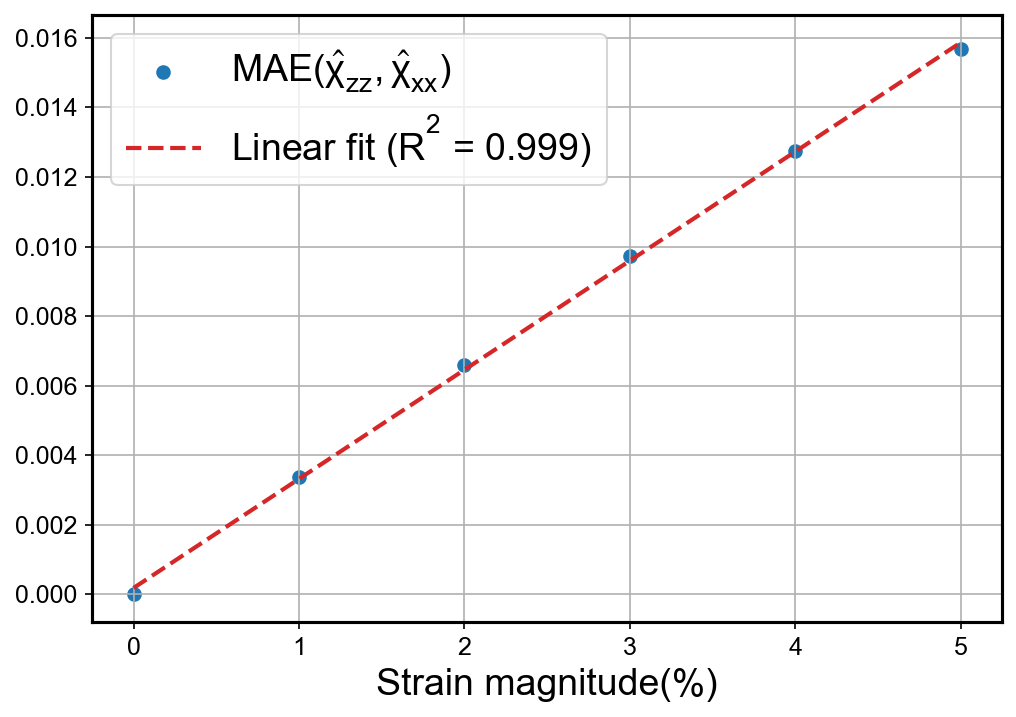

In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Matplotlib style settings for a high-quality, clean plot
fontsize = 18
textsize = 12
plt.rcParams.update({
    "font.size": fontsize-4,
    "axes.labelsize": fontsize,
    "axes.titlesize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": textsize,
    "ytick.labelsize": textsize,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.0,
    "savefig.dpi": 300,
    "figure.dpi": 150
})

df["delta_zz_xx"] = df["y_pred_cart"].map(lambda x: np.abs(x[:, 2, 2] - x[:, 0, 0]))
# df["delta_zz_xx"] = df["y_pred_cart"].map(lambda x: np.abs(x[:, 0, 2]))

strain_values = []
mean_anisotropies = []

# Extract strain values and compute means
for index, row in df.iterrows():
    strain_str = re.findall(r"strain_(-?\d+\.?\d*)", row["mp_id"])
    if strain_str:
        strain = float(strain_str[0])
        mean_aniso = np.mean(row["delta_zz_xx"])
        strain_values.append(strain)
        mean_anisotropies.append(mean_aniso)

# Sort by strain
strain_values, mean_anisotropies = zip(*sorted(zip(strain_values, mean_anisotropies)))
strain_values = np.array(strain_values).reshape(-1, 1)
mean_anisotropies = np.array(mean_anisotropies)

# Linear regression fit
model = LinearRegression()
model.fit(strain_values, mean_anisotropies)
predictions = model.predict(strain_values)
r2 = r2_score(mean_anisotropies, predictions)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
# ax.scatter(strain_values, mean_anisotropies, color='tab:blue', label=r"$\hat{{\overline{\chi}}}_{xz}$ (F/m)")
ax.scatter(strain_values, mean_anisotropies, color='tab:blue', label=r"MAE($\hat{\chi}_{zz},\hat{\chi}_{xx}$)")

ax.plot(strain_values, predictions, color='tab:red', linestyle='--', label=fr"Linear fit ($R^2$ = {r2:.3f})")

ax.set_xlabel(r"Strain magnitude(%)")
# ax.set_xlabel(r"Shear strain angle (degree)")

# ax.set_ylabel(r"$|\hat{\overline{\overline{\chi}}}_{zz}-\hat{\overline{\overline{\chi}}}_{xx}|$ (F/m)")
# ax.set_ylabel(r"$\hat{{\overline{\chi}}}_{xz}$ (F/m)")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

